# Istogrammi in ROOT, gestione file e macro

In questo notebook andremo a vedere come è possibile gestire i file con estensione .root, comunemente infatti il framework ROOT viene usato per analizzare gli elementi derivate dall'acquisizione di dati, salvati in formato .root appunto.

Successivamente andremo a vedere l'ultima classe fondamentale dell'analisi dati con ROOT:  TH1, che gestisce gli istrogrammi.

Infine vedremo come si possono creare macro eseguibili in ambiente ROOT e integrare ROOT in un codice C++ compilabile.

**!!! importante** 

Nel file seguente alcune istruzioni (import ROOT e %%cpp) sono usate solo e soltanto per far funzionare il codice sul notebook, non vanno usate nel framework!

In [1]:
import ROOT
#al solito questo serve solo per importare root nel notebook non serve scriverlo nel framework

Welcome to JupyROOT 6.14/06


## TFile

I [TFile](https://root.cern.ch/doc/master/classTFile.html) sono una classe Root che si occupa di aprire, modificare e spostarsi nei file .root all'interno del framework.

Una volta in possesso di un file .root che si vuole aprire per farvi analisi dati (ad esempio un file contenente delle misurazioni salvate come istrogramma) vi sono due modi per aprirlo nel framework:

1. Il modo più semplice per aprire un file all'interno del framework è direttamente dal terminale al momento dell'apertura di root dare il nome del file, as esempio l'istruzione

     - root -l 100mSimK12_trigger.root

Aprirà il file 100mSimK12_trigger.root all'interno del framework e il suo contenuto (molti istogrammi) diventerà direttamente utilizzabile, (nel fare ciò viene aperto automaticamente un TFile a cui viene assegnato il file)

2. E' possibile aprire il file "manualmente" quando si è già all'interno di root tramite appunto l'uso dei TFile.

Il costruttore di un TFile (al parte quello di default) è:

TFile::TFile	(	const char * 	fname1,
Option_t * 	option = "",
const char * 	ftitle = "",
Int_t 	compress = ROOT::RCompressionSetting::EDefaults::kUseGeneralPurpose 
)	

Come potete vedere l'unico paramentro "obbligatorio" è il nome del file, gli altri paramentri sono opzionali.
E' importante ricordare che quando si apre un file spesso è importante dare al costruttore oltre al nome un'opzione che identifica l'uso che si farà del file:
    - CREATE crea un nuovo file se non ne esistono con lo stesso nome
    - RECREATE crea un nuovo file e sovrascrive quello vecchio se hanno lo stesso nome
    - UPDATE apre un file con possibilità di modificarlo
    - READ apre un file in sola lettura
    
Nel notebook è possibile usare solo questa seconda opzione, ad esempio proviamo ad aprire il file 100mSimK12_trigger:


In [2]:
%%cpp
TFile *file = new TFile ("100mSimK12_trigger.root"); //creo un Tfile con cui gestire 100mSimK12_trigger
file->cd(); // mi sposto nel file tramite il TFile

Quando siete nel framework per vedere il contenuto di un file è sufficiente mandare l'istruzione .ls e a scehrmo verranno scritti tutti gli oggetti contenuti (sul notebook non funziona perchè non è cpp nativo).

Una volta aperto è possibile usare tutti gli elementi all'interno, per esempio nel file vi è un istogramma chiamato BsMass (vedremo poi gli istogrammi nel dettaglio) e quindi possiamo direttamente stamparlo

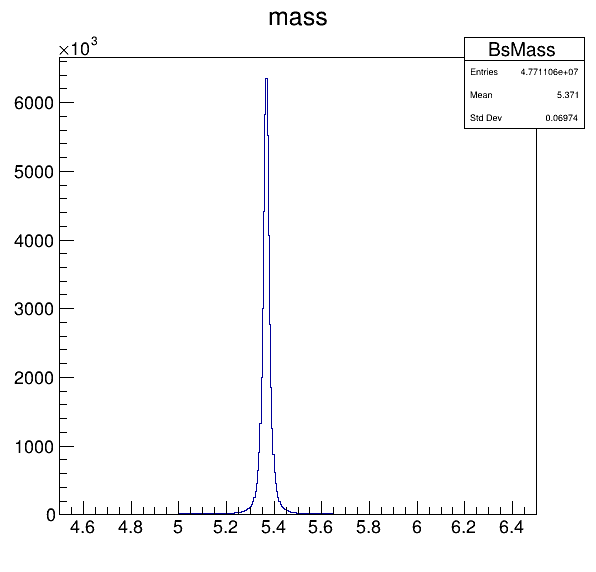

In [3]:
%%cpp
TCanvas *c= new TCanvas("c", "c", 600, 600);
c->cd();
BsMass->Draw();
c->Draw()

E' estremamente importante sapere che una volta che un file viene aperto e modificato (per esempio quando create funzioni, fate fit eccetera) le modifiche NON vengono mai salvate automaticamente, questo è utile visto che permette di modificare "in modo sicuro" gli oggetti senza modificarli in modo irreversibile.

Per salvare ciò che avete prodotto e/o modificato è necessario chiamare il metodo Write che scrive nel file corrente gli elementi che avete creato.

Il modo con cui viene gestita la memoria è estremamente complicato quindi non vedremo nel dettaglio come funziona, in generale è sufficiente una volta che si è nel file chiamare il metodo write reimplementato per un particolare oggetto; ad esempio:


In [4]:
%%cpp
TFile *file2= new TFile("file.root", "RECREATE"); //creo un nuovo file ( lo sovrascrivo se gia esiste)
//state molto attenti a CREATE/RECREATE perche la sovrascrittura e irreversibile
file2->cd(); //mi sposto nel file
TF1 *f1= new TF1("f1", "sin(x)", 0,4); //creo una funzione

Se a questo punto scrivete .ls per vedere gli elementi nel file non vedrete nulla (non la TF1 almeno) questo perchè non l'avete ancora salvata:

In [5]:
%%cpp
f1->Write(); //scrivo la funzione nel file
file2->Close(); //chiudo il file cosi da vedere se si e salvato davvero

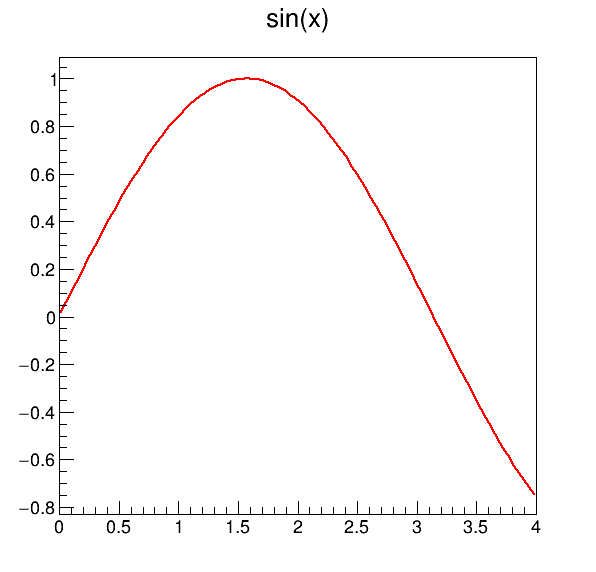

In [6]:
%%cpp
TFile *file3= new TFile("file.root", "READ"); //apro il file di prima in modalita lettura
file3->cd(); //mi sposto nel file
TCanvas *c2=new TCanvas("c2", "c2", 600, 600);
c2->cd();
f1->Draw(); //disegno la funzione che prima ho salvato
c2->Draw();


Se poi volessi riaprire il file per modificarlo lo dovrò aprire in modalità "UPDATE"

## TH1

I [TH1](https://root.cern.ch/doc/master/classTH1.html) sono una delle classi più importanti di ROOT.
I TH1 si occupano della gestione degli istogrammi 1-dimensionali e vengono reimplementati in sostanzialmente tre opzioni, che sono le classi concrete che useremo:
    - TH1F istogramma dove i dati ricevuti sono float
    - TH1D istogramma dove i dati ricevuti sono double
    - TH1I istogramma dove i dati ricevuti sono interi
    
Nei seguenti esempi useremo sostanzialmente solo i TH1F ma tutto ciò che diremo vale anche per gli altri.

**Nota**
Esistono le rispettive classi TH2F, TH2D, TH2I che gestiscono gli istogrammi bidimensionali (poco usati)

Come potete vedere dalla documentazione i TH1 hanno una quantità di metodi enorme, in ogni caso il costruttore più usato (si usa sempre questo a meno che non vogliate fare istogrammi a binning variabile) è:

    TH1 (const char *name, const char *title, Int_t nbinsx, Double_t xlow, Double_t xup)
    
Che chiede nome, titolo, numero di bin, e range (min e max).
Per riempire l'istrogramma esiste poi un metodo chiamato Fill che chiede in input un dato oppure un dato e il suo peso, mentre per disegnarlo esiste una reimplementazione del metodo Draw.

Facciamo un esempio:

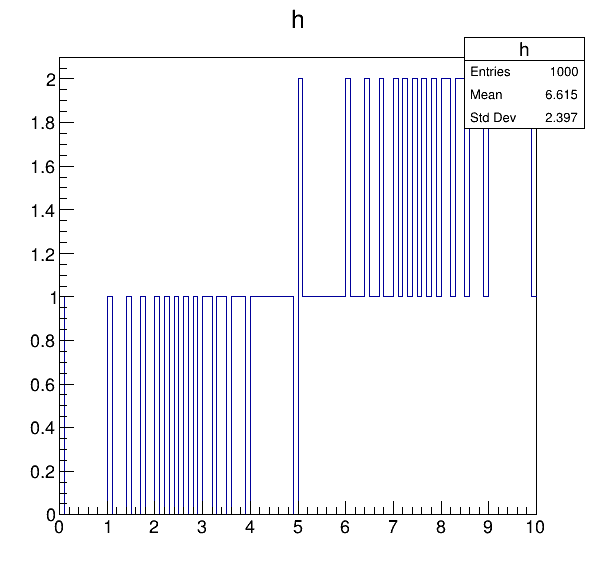

In [7]:
%%cpp

TH1F *h=new TH1F("h","h", 100, 0,10); //creo un istrogramma con dati da 0 a 10 e 100 bin
//faccio un ciclo con cui creare un po di dati da inserire nell istrogramma
for (int i=0; i<1000; i++){
    double t=sqrt(i);
    h->Fill(t);
}
TCanvas *c3=new TCanvas("c3", "c3", 600, 600);
c3->cd();
h->Draw(); //disegno la funzione che prima ho salvato
c3->Draw();


Questo istogramma è particolarmente brutto (i dati sono generati un po' a caso) quindi proviamo a fare qualcosa di più interessante: nel file LD30kAngle.txt ci sono tre colonne che rappresentano massa ricostruita (con valore tra 5 e 6), distanza e suo errore nel decadimento del $B^0_S$, proviamo a creare l'istogramma della massa ricostruita:

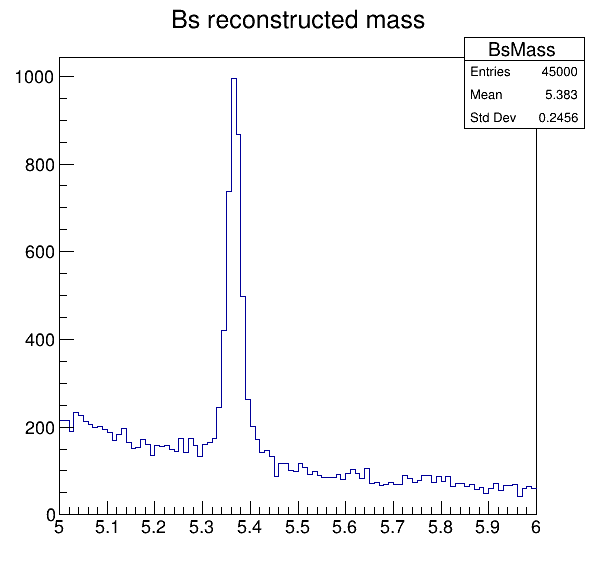

In [8]:
%%cpp
//creo un tfile in cui salvare i dati poi 
TFile *Bs=new TFile("BsMass.root", "RECREATE");
//ora devo caricare i dati per farlo uso un ifstream
ifstream in ("LD30kAngle.txt");
//creo un TH1F in cui caricare i dati
TH1F *BsMass = new TH1F ("BsMass", "Bs reconstructed mass", 100, 5, 6); // 100 bin tra 5 e 6
//ora faccio un ciclo con cui caricare i dati
double m,d,e;
while (in>>m){
    in>>d,e; //bisogna ricevere una riga intera anche se poi d ed e non li uso
    BsMass->Fill(m); //carico la massa nell istogramma
}
BsMass->Write();// salvo il Th1f nel file

//ora proviamo a disegnarlo
TCanvas *cbs= new TCanvas("cbs", "Bs Mass", 600, 600);
cbs->cd();
BsMass->Draw();
cbs->Draw();



In questo modo avendo un qualsiasi file txt contenente dei dati su cui si vuole costruire un istrogramma possiamo caricarlo in un TH1F.

### Lavorare sui TH1

La classe TH1 permette di fare moltissime cose con gli istogrammi dal semplice fit alla pulizia del fondo (se si hanno le misure del fondo ovviamente).

I metodi implementati gestiscono tutte queste operazioni: nel file 100mSimK12_trigger sono presenti molti TH1F con cui possiamo provare a lavorare.

**Nota**
Nei codici qui sono non andrò a salvare gli istogrammi modificati o creati per non sovrascrivere/modificare il file, in ogni caso ricordate che qualsiasi cosa creata/modificata viene salvata con Write()

**Nota 2** 
Tutti quello che c'è nel file si può già subito usare senza dover usare costruttori o fare operazioni

In [9]:
%%cpp
//apriamo il file
TFile *hfile = new TFile ("100mSimK12_trigger.root"); //creo un Tfile con cui gestire 100mSimK12_trigger
hfile->cd()

(bool) true


Proviamo per esempio a plottare l'istrogramma hAll e a fittarlo con una funzione:

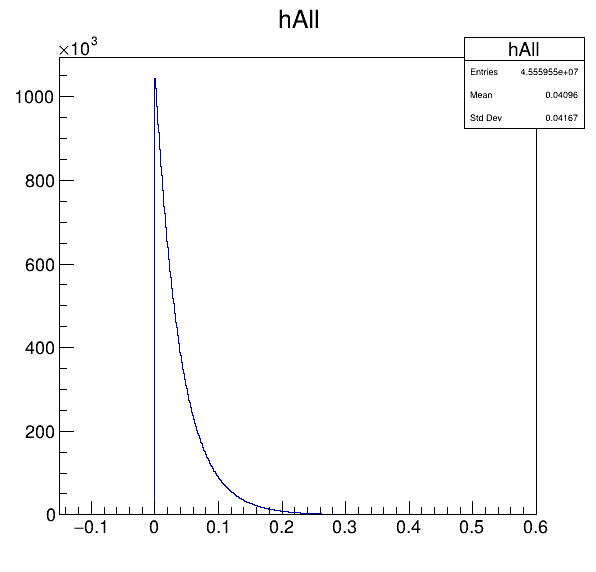

In [10]:
%%cpp
//creo un canvas in cui plottare
TCanvas *call= new TCanvas("call", "call", 600, 600);
call->cd();
hAll->Draw(); //disegno l'istogramma
call->Draw();

 FCN=7795.02 FROM MIGRAD    STATUS=CONVERGED      49 CALLS          50 TOTAL
                     EDM=8.38171e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.38627e+01   2.19426e-04   6.61024e-06   2.75144e-01
   2  Slope       -2.45760e+01   4.11317e-03   1.20256e-04   1.08292e-02
chi2 :7795.02
NDF  :211


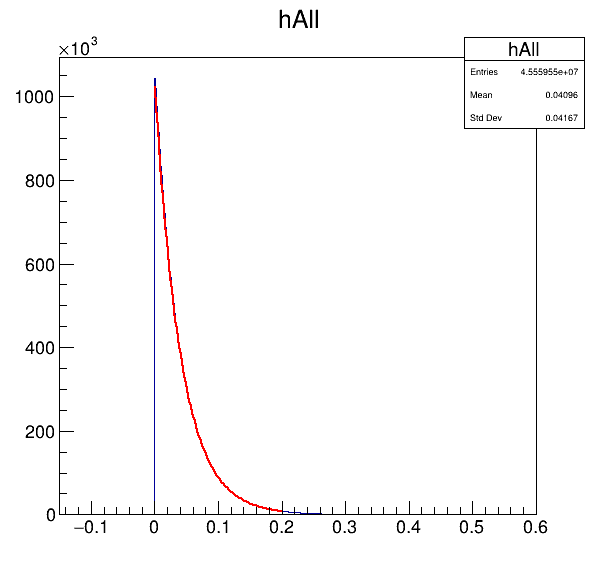

In [11]:
%%cpp
//proviamo a fittarlo con un esponenziale
//creo la funzione esponenziale
TF1 *fexp= new TF1("fexp", "expo", 0, 0.2);
//fitto la funzione al Th1 
hAll->Fit("fexp", "R");
call->Draw(); //riplotto il canvas

//e ora facciamoci dire chi quadro e NDF
cout<<"chi2 :"<<fexp->GetChisquare()<<endl;
cout<<"NDF  :"<<fexp->GetNDF()<<endl;

Supponiamo ora per esempio di avere un istogramma (ad esempio quello del Bs) dove è presente un fondo e di averne poi uno rappresentante il suo fondo.

E' possibile ottenere quindi l'istogramma "ripulito" sottraendo (o meglio sommando negativamente) i due istogrammi.
Per fare questo esiste il metodo **Add(TH1, double)** (in tre implementazioni ma a noi interessa una solo) che richiede in input un secondo istogramma e il peso con cui eseguire la somma.

Altri metodi utili per l'analisi (o per estrarre dati)  sono i metodi 
    - SetBinContent(int)
    - GetBinContent(int, double)
    - GetNbinsX()

Che rispettivamente settano e restituiscono il valore dell'i-esimo bin dell'istrogramma in analisi e restituiscono il numero totale di Bins

Proviamo a fare un esempio: nel grafico di prima (il Bs) è chiaramente visibile che il fondo è sempre inferiore a 200 (intendendo il valore dei bin di fondo), proviamo allora a fare questa cosa, in un canvas diviso in tre plotteremo l'istogramma, una sua copia in cui i bin con contenuto maggiore di 200 vengono azzerati (con i metodi di prima) e la differenza dei due.

Per copiare un istogramma, in particolare se non si conosce bene il binning o i dati da cui si è partiti è possibile usare i metodi sopra ma risulta molto più semplice usare il metodo **Clone** il quale appunto clona un TH1.

In [12]:
%%cpp
TCanvas *can5= new TCanvas("can5", "can5", 1200, 400); //creo il canvas e lo divido
can5->Divide(3,1); //divido il canvas

//facciamo le copie degli istogrammi, bisogna essere un po accorti mentre si chiama clone
//chiamare clone non basta, serve anche eseguire un cast durant l assegnazione
TH1F *BsMassBkg= (TH1F*)BsMass->Clone();
TH1F *BsMassSub= (TH1F*)BsMass->Clone();

int n; //la dichiaro qua ma mi serve dopo

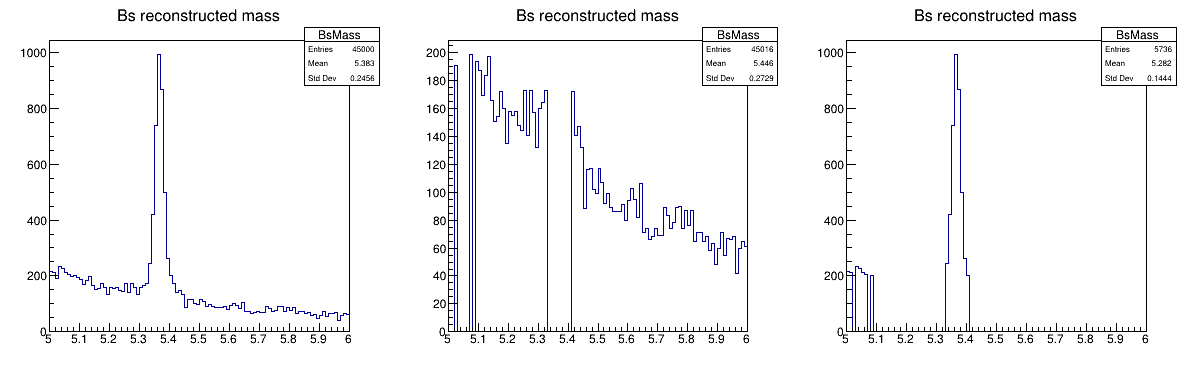

In [13]:
%%cpp
can5->cd(1);
//plottiamo l originale
BsMass->Draw();

can5->cd(2);
//ora modifichiamo la copia, possiamo 
//ininnanzitutto mi serve sapere quanti bin ci sono
n=BsMass->GetNbinsX();
//eseguo un ciclo su tutti i bin
for (int i =0; i<n; i++){
    //faccio un if ricevendo il numero di dati in ogni bin
    if (BsMassBkg->GetBinContent(i)>200){
        //se il numero e maggiore di 200 lo azzero cosi da avere solo il fondo
        BsMassBkg->SetBinContent(i, 0);
    }
}
//disegno l istogramma di fondo
BsMassBkg->Draw();

can5->cd(3);
//ora sottraggo l istogramma di fondo a quello originale, per farlo basta sommarli am dando un peso negativo
BsMassSub->Add(BsMassBkg, -1);
BsMassSub->Draw();

can5->Draw();

Una richiesta molto comune nell'analisi di un istogramma è il calcolo del suo integrale in un dato range, per fare questo esiste il metodo Integral(min, max).

E' necessario stare attenti poichè Integral richiede in input il min e max intesi come numero di bin non come range nelle unità del grafico.

Per conoscere il particolare numero di un bin esiste il metodo FindBin() il quale riceve una coordinata in "UserUnit" e restituisce il bin corriscondente.

Supponiamo per esempio di voler conoscere il valor dell'integrale (che corrisponde al numero di eventi) tra 5.3 e 5.4 dell'istogramma precedente, basterà allora fare:

In [16]:
%%cpp
//qui serve mettere cout nel framework non e necessario
cout<<BsMass->FindBin(5.3)<<endl;
cout<<BsMass->FindBin(5.4)<<endl;

30
41


In [17]:
%%cpp
//ora posso integrare o mettendo i numeri a schermo oppure chiamando di nuovo findbin
cout<<BsMass->Integral(BsMass->FindBin(5.3),BsMass->FindBin(5.4));

4856